In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import VAE
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import diffusion_dist as diff
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dataset import *
import scipy

In [2]:
pd_atac = pd.read_csv('./data/expr_atac_processed.csv', index_col=0)
pd_rna = pd.read_csv('./data/expr_rna_processed.csv', index_col=0)
atac = pd_atac.to_numpy()
rna = pd_rna.to_numpy()

In [3]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    return dist 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = scDataset(dim_reduction=False)

# Similarity matrix
Note that for distance calculation, dimension reduction is necessary as raw data is too noisy
## Diffusion map distance

In [5]:
pca = PCA(n_components=30)

atac_lsi = latent_semantic_indexing(atac, k = 30)
atac_pca = pca.fit_transform(atac)

rna_pca = pca.fit_transform(np.log1p(rna))

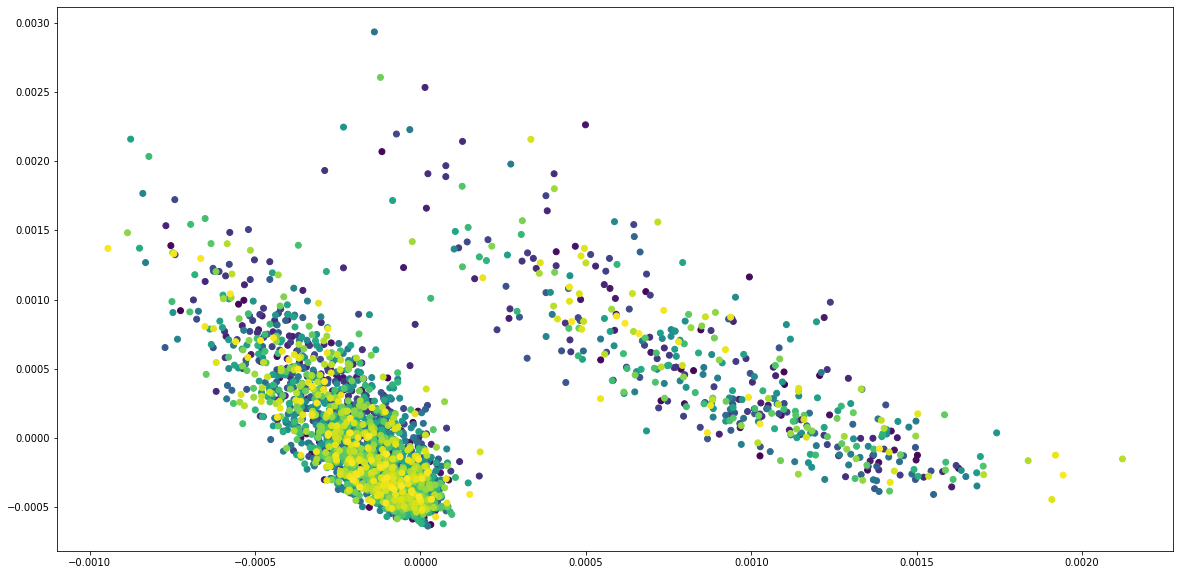

In [9]:
diffu_atac = diff.diffusion_map(atac_pca, n_eign = 10, alpha = 100, diffusion_time = 5)
diff_sim_atac = diff.diffusion_similarity(diffu_atac)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu_atac[:,2], diffu_atac[:,1], c=np.arange(atac.shape[0]))

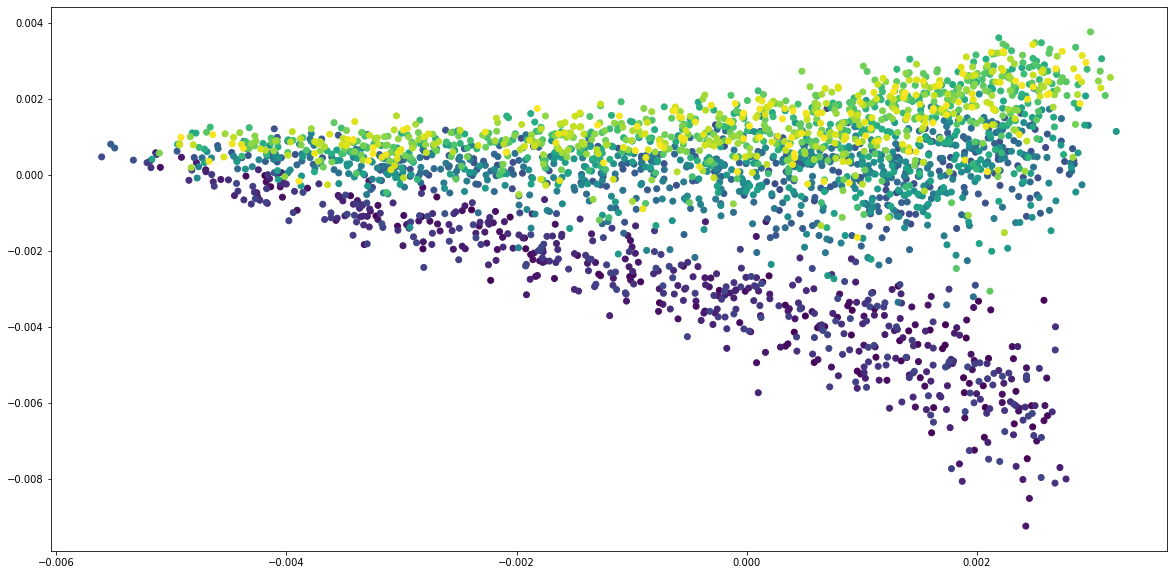

In [10]:
diffu = diff.diffusion_map(rna_pca, n_eign = 10, alpha = 15, diffusion_time = 5)
diff_sim_rna = diff.diffusion_similarity(diffu)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,1], diffu[:,2], c=np.arange(rna.shape[0]))


In [12]:
# normalize both matrices for inner product loss
diff_sim_atac = torch.FloatTensor(diff_sim_atac).to(device)
diff_sim_rna = torch.FloatTensor(diff_sim_rna).to(device)
diff_sim_atac = diff_sim_atac / torch.norm(diff_sim_atac, p = 'fro')
diff_sim_rna = diff_sim_rna / torch.norm(diff_sim_rna, p = 'fro')

## Diffusion pseudot-time distance

[**graph tools** package api](https://graphtools.readthedocs.io/en/stable/reference.html#module-graphtools.api)


graph tools is a package developed by yale **PHATE group** that doing specifically for trajectory inference of single cell dataset


**Colab manuscript**:


https://colab.research.google.com/github/KrishnaswamyLab/SingleCellWorkshop/blob/master/exercises/TrajectoryInference/notebooks/00_Answers_Pseudotime_from_scratch.ipynb#scrollTo=VP-LwFopT40s

In [13]:
# !conda install -c conda-forge graphtools

In [7]:
def calculateDPT(data):
    '''Calculates DPT between all points in the data, directly ouput similarity matrix, which is the diffusion pseudotime matrix, a little better than diffusion map
    Parameters:
        data: feature matrix, numpy.array of the size [n_samples, n_features]
    
    Returns:
        DPT: similarity matrix calculated from diffusion pseudo-time
    '''
    import graphtools as gt
    from scipy.spatial.distance import pdist, squareform
    # Calculate from raw data would be too noisy, dimension reduction is necessary, construct graph adjacency matrix with n_pca 100
    G = gt.Graph(data, n_pca=100, use_pygsp=True)
    
    # Calculate eigenvectors of the diffusion operator
    # G.diff_op is a diffusion operator, return similarity matrix calculated from diffusion operation
    W, V = scipy.sparse.linalg.eigs(G.diff_op, k=1)
    
    # Remove first eigenspace
    T_tilde = G.diff_op.toarray() - (V[:,0] @ V[:,0].T)
    
    # Calculate M
    I = np.eye(T_tilde.shape[1])
    M = np.linalg.inv(I - T_tilde) - I
    M = np.real(M)
    
    # Calculate DPT
    DPT = squareform(pdist(M))
    
    # DPT = torch.FloatTensor(DPT).to(device)
    return DPT

In [15]:
# pca calculated internally, no need to do pca before
DPT_atac = diff.DPT_similarity(atac)
DPT_rna = diff.DPT_similarity(rna)

# normalize both matrices for inner product loss
DPT_atac = torch.FloatTensor(DPT_atac).to(device)
DPT_rna = torch.FloatTensor(DPT_rna).to(device)
DPT_atac = DPT_atac / torch.norm(DPT_atac, p = 'fro')
DPT_rna = DPT_rna / torch.norm(DPT_rna, p = 'fro')

In [20]:
def dist_loss(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, lamb, dist_loss_type = "cosine"):
    loss_recon_rna = F.mse_loss(rna, recon_rna)
    loss_recon_atac = F.mse_loss(atac, recon_atac)

    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))

    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna

In [26]:
def train_ae(model, lamb = 1, similarity = "DPT"):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z = model(batch_atac, batch_rna)

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        elif similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]
        loss = dist_loss(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, lamb = lamb, dist_loss_type= 'cosine')
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]
        current_loss = loss[0]
        current_loss.backward()
        optimizer.step()
    
    return total_loss.item() / len(dataset), total_loss_recon_rna.item() / len(dataset), total_loss_recon_atac.item()/ len(dataset), \
 total_loss_dist_rna.item() / len(dataset), total_loss_dist_atac.item() / len(dataset)

In [22]:
def test(model):
    data_loader_test = DataLoader(dataset, batch_size=len(dataset),shuffle=False)
    for data in data_loader_test:
        _, _, z = model(torch.FloatTensor(data['ATAC']).to(device), data['RNA'].to(device))
    z = z.detach().cpu().numpy()
    return z

## AutoEncoder
Diffusion map as similarity matrix

In [23]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=32)

model_ae = AutoEncoder(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=16, latent_channels_rna=16, latent_channels_z=2, layer1_channels = 512, layer2_channels = 128).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 30):

    loss, l1, l2, l3, l4 = train_ae(model_ae, lamb = 10, similarity = "diffusion map")
    if epoch % 10 == 0:
        print("Epoch: ", epoch, "Total loss:", loss, "Recon RNA loss: ", l1, "Recon ATAC loss: ", l2, "Dist RNA loss: ", l3, "Dist ATAC loss", l4)

Epoch:  0 Total loss: 0.02623791822832852 Recon RNA loss:  0.02974402511810453 Recon ATAC loss:  0.001125203800309747 Dist RNA loss:  -0.002190845566055893 Dist ATAC loss -0.0024404670198231834
Epoch:  10 Total loss: 0.014202093364884573 Recon RNA loss:  0.01912463013758401 Recon ATAC loss:  0.001014226225911104 Dist RNA loss:  -0.0028357937317010085 Dist ATAC loss -0.0031009700793923865
Epoch:  20 Total loss: 0.014159620372421224 Recon RNA loss:  0.019102137723415017 Recon ATAC loss:  0.0010155086849549194 Dist RNA loss:  -0.0028489601065922036 Dist ATAC loss -0.003109067464046341


array([[-0.293286  ,  0.43573275],
       [-0.29309583,  0.4343106 ],
       [-0.29240316,  0.4330032 ],
       ...,
       [-0.29601008,  0.43283743],
       [-0.2957183 ,  0.43233183],
       [-0.29576287,  0.43219346]], dtype=float32)

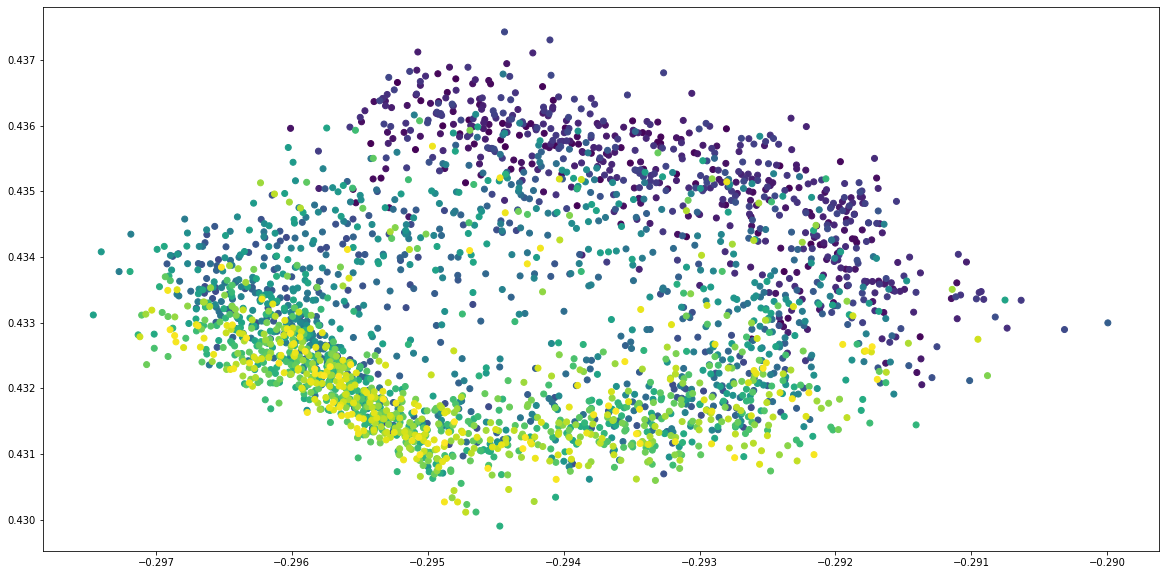

In [24]:
z = test(model_ae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))
z

DPT as similarity matrix

In [28]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=32)

model_ae = AutoEncoder(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=16, latent_channels_rna=16, latent_channels_z=2, layer1_channels = 512, layer2_channels = 128).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 30):

    loss, l1, l2, l3, l4 = train_ae(model_ae, lamb = 100, similarity = "DPT")
    if epoch % 10 == 0:
        print("Epoch: ", epoch, "Total loss:", loss, "Recon RNA loss: ", l1, "Recon ATAC loss: ", l2, "Dist RNA loss: ", l3, "Dist ATAC loss", l4)

Epoch:  0 Total loss: -0.02456575485397044 Recon RNA loss:  0.02910085358162894 Recon ATAC loss:  0.0011643790151530348 Dist RNA loss:  -0.026747602804372456 Dist ATAC loss -0.02808339683362274
Epoch:  10 Total loss: -0.040829107825478925 Recon RNA loss:  0.01912772551669807 Recon ATAC loss:  0.001014526573738696 Dist RNA loss:  -0.029804999608968253 Dist ATAC loss -0.031166351098808453
Epoch:  20 Total loss: -0.04086280022548573 Recon RNA loss:  0.019113076270326254 Recon ATAC loss:  0.0010146467309249075 Dist RNA loss:  -0.029779320817605783 Dist ATAC loss -0.031211194374578463


array([[ 0.549186  , -0.6710563 ],
       [ 0.5489553 , -0.66943276],
       [ 0.55638766, -0.6656073 ],
       ...,
       [ 0.54352033, -0.6484109 ],
       [ 0.53479296, -0.65079045],
       [ 0.5346792 , -0.6565629 ]], dtype=float32)

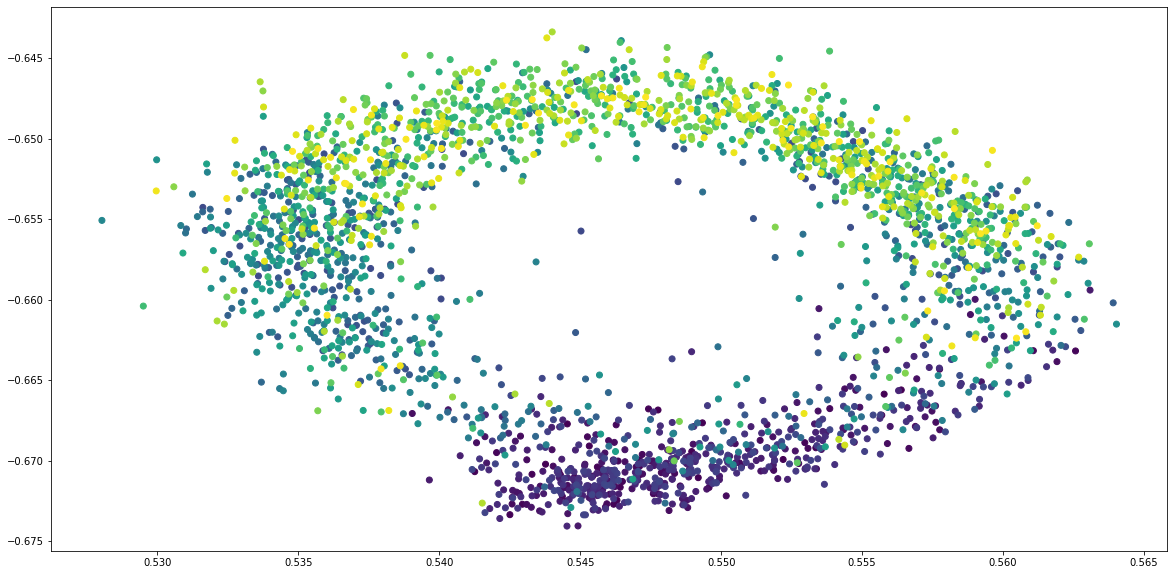

In [29]:
z = test(model_ae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))
z

## Variational AutoEncoder

In [ ]:
def dist_loss_kl(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, lamb, dist_loss_type = "cosine"):
    loss_recon_rna = F.mse_loss(rna, recon_rna)
    loss_recon_atac = F.mse_loss(atac, recon_atac)

    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))

    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna

In [ ]:
def train_vae(model, lamb = 1, similarity = "DPT"):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z = model(batch_atac, batch_rna)

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        elif similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]
        loss = dist_loss(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, lamb = lamb, dist_loss_type= 'cosine')
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]
        current_loss = loss[0]
        current_loss.backward()
        optimizer.step()
    
    return total_loss.item() / len(dataset), total_loss_recon_rna.item() / len(dataset), total_loss_recon_atac.item()/ len(dataset), \
 total_loss_dist_rna.item() / len(dataset), total_loss_dist_atac.item() / len(dataset)

In [25]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=32)

model_vae = model.vae.VAE(in_channels_atac=1000, in_channels_rna=rna.shape[1], latent_channels_atac=8, latent_channels_rna=8, latent_channels_z=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 51):

    loss = train_vae(model, lamb = 1-, similarity = "DPT")
    if epoch % 10 == 0:
        print("Epoch: ", epoch, "loss:", loss)

Epoch:  0 loss: 1.5221446917301684
Epoch:  10 loss: 0.035532716276608645
Epoch:  20 loss: 0.035580659264734596
Epoch:  30 loss: 0.035440455779393754
Epoch:  40 loss: 0.03528248600235765
Epoch:  50 loss: 0.035296485262447934


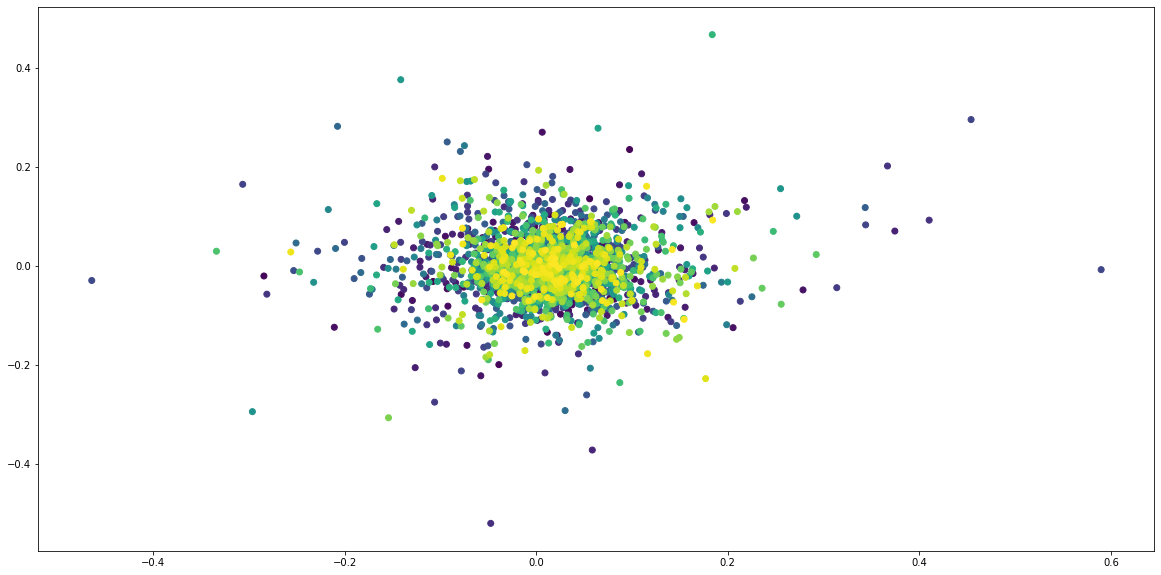

In [32]:
z = test(model_vae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))